# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


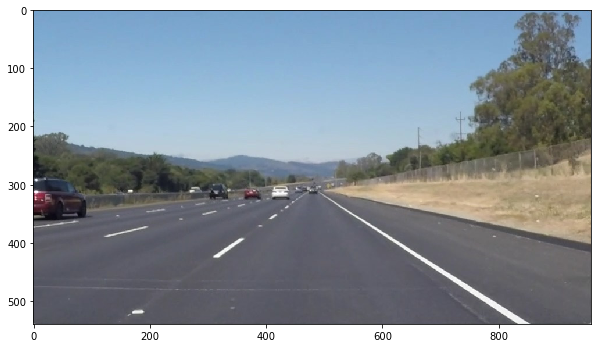

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [31]:
import math

def read_image(fname):
    """
    Reads file and returns image
    """
    if not os.path.isfile(fname):
        raise FileNotFoundError

    return mpimg.imread(fname)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def create_roi_vertices(image):
    """
    Creates the vertices of a trapezoid that is used as the region of interest.
    """
    xsize =  image.shape[1]
    ysize =  image.shape[0]
    
    yRatio = 0.59
    xRatio = 0.17
    xRatioTop = 0.9375
    
    #    *--------*
    #   /          \
    #  /            \
    # *--------------*
    
    # y value for both, top left and right points of the trapezoid
    top = int(round(yRatio * ysize))
    
    # x value of the left bottom point, the right one is imagewidth - xLenBottom
    xLenBottom = int(round(xRatio * xsize)/2)
    
    # x value of the left TOP point, the right one is imagewidth - xLenTop
    xLenTop = int(round(xRatioTop * xsize)/2)
    
    # defines the trapezoid
    trap_left_bottom = (xLenBottom,ysize)
    trap_left_top = (xLenTop, top)
    trap_right_top = (xsize-xLenTop, top)
    trap_right_bottom = (xsize-xLenBottom,ysize)
    
    vertices = np.array([[trap_left_bottom, trap_left_top, trap_right_top, trap_right_bottom]], dtype=np.int32)
    
    return vertices

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def calc_slope_and_intercept(x1, y1, x2, y2):
    """
    Calculates the slope and intercept values for two points.    
    """
    deltaX = x2 - x1
    
    # Division by 0 is not allowed. Therefore check deltaX
    if math.fabs(deltaX) < 0.00001:
        return float('NaN'), float('NaN')
    
    slope = (y2-y1) / (x2-x1)
    
    # y = mx * b => b = -mx + y
    intercept = (-1) * slope * x1 + y1
    
    return slope, intercept

def get_line(slope, intercept, y1, y2):
    """
    Calculates the start and end point based on given slope and intercept values
    and the y start and end values of two points.
    """
   
    # we do not take invalid slopes as well as slope values which are below 0.5
    # into account.
    #if math.fabs(slope) < 0.5 or np.isnan(slope) or np.isnan(intercept):
    if np.isnan(slope) or np.isnan(intercept) or math.fabs(slope) < 0.45:
        return []
    
    calc_x = lambda y,m,b : int(round((y - b) / m))
    
    x1 = calc_x(y1,slope,intercept)
    x2 = calc_x(y2,slope,intercept)
    
    #print("x1 : %d, y1 : %d, x2 : %d, y2 : %d, slope: %f, intercept : %f" % (x1,y1,x2,y2,slope,intercept))
    
    return [(x1,y1), (x2,y2)]

def separate_lines(img, lines, draw_lines = True):
    """
    separates left from right lane lines and returns them 
    """
    color = [0, 255, 0] 
    thickness = 2    
    left = []
    right = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            # lines with an invalid slope will not be taken into account
            slope,intercept = calc_slope_and_intercept(x1, y1, x2, y2)                                
                                  
            if np.isnan(slope):
                continue
                               
            # This line belongs to the left lines if the x value of the second point x2
            # is smaller then imagewidth/2.
            if x2 < img.shape[1]/2:
                left.append((x1, y1, x2, y2,slope,intercept))
            else:
                right.append((x1, y1, x2, y2,slope,intercept))
               
            # Draw lines
            if draw_lines:
                cv2.line(img, (x1,y1), (x2,y2), color, thickness)
    
    # remove outliers
    left_median = np.median(np.array([slope for _, _, _, _, slope, _ in left]))
    right_median = np.median(np.array([slope for _, _, _, _, slope, _ in right]))
    
    # keep only those points whose slopes are not greater or less than 20% of the median
    deltaLeft = math.fabs(left_median) * 0.15
    deltaRight =  math.fabs(right_median) * 0.15
    
    left_new = [[x1, y1, x2, y2] for (x1, y1, x2, y2, slope, intercept) in left 
               if left_median - deltaLeft <= slope and slope <= left_median + deltaLeft]
    
    right_new = [[x1, y1, x2, y2] for (x1, y1, x2, y2, slope, intercept) in right 
               if right_median - deltaRight <= slope and slope <= right_median + deltaRight]
        
    return left_new, right_new
 
def extrapolate(lines, from_, to_):
    from scipy import stats
    
    pointsX = []
    pointsY = []
    
    for x1,y1,x2,y2 in lines:
        pointsX.append(x1)
        pointsX.append(x2)
        pointsY.append(y1)
        pointsY.append(y2)

    slope, intercept, r_value, p_value, std_err = stats.linregress(pointsX, pointsY)      
    
    return get_line(slope, intercept, from_, to_)
        
def draw_lines(img, left, right,from_, to_, color=[255, 0, 0], thickness=2):
    """
    Draws a single line over the left and right lane. It does a linear regression
    and calculates the top and bottom point for the calculated line.
    """        
    if len(left) > 0:
        leftPoints = extrapolate(left, from_, to_)

        if (len(leftPoints) > 0):        
            cv2.line(img, leftPoints[0], leftPoints[1], color, thickness)

    if len(right) > 0:
        rightPoints = extrapolate(right, from_, to_)

        if (len(rightPoints) > 0):
            cv2.line(img, rightPoints[0], rightPoints[1], color, thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    return (line_img, lines)

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
test_dir = 'test_images'
test_images = os.listdir(test_dir)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

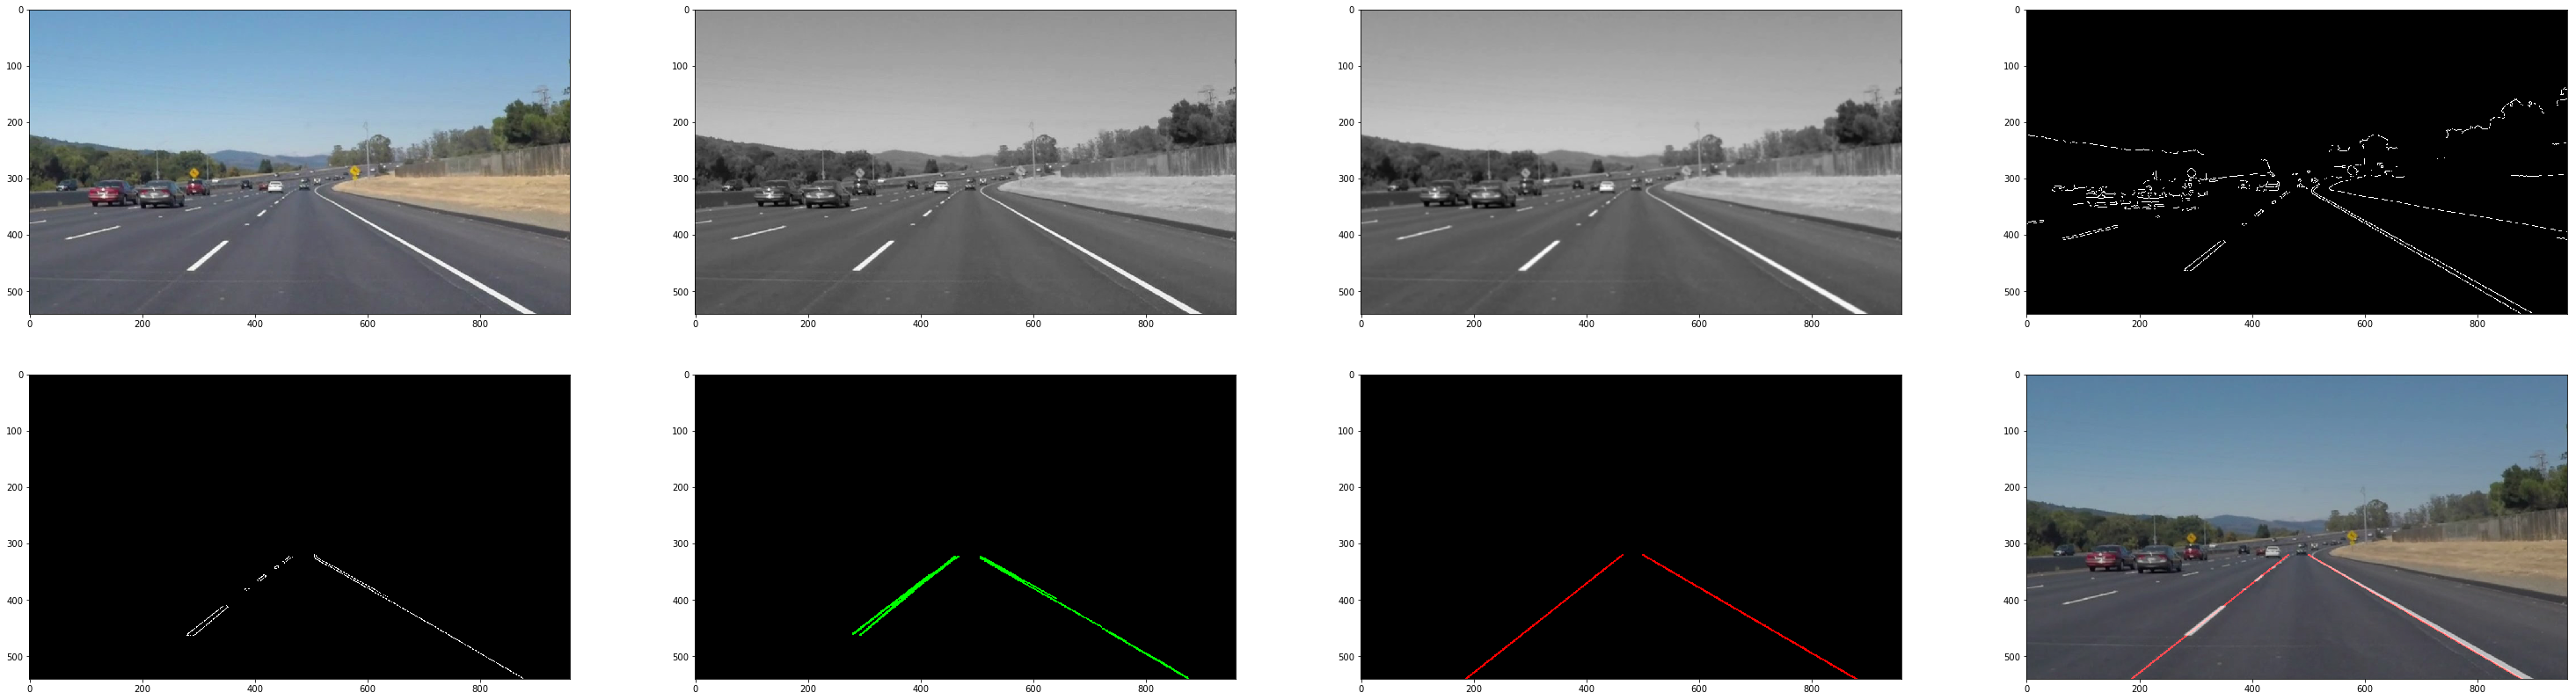

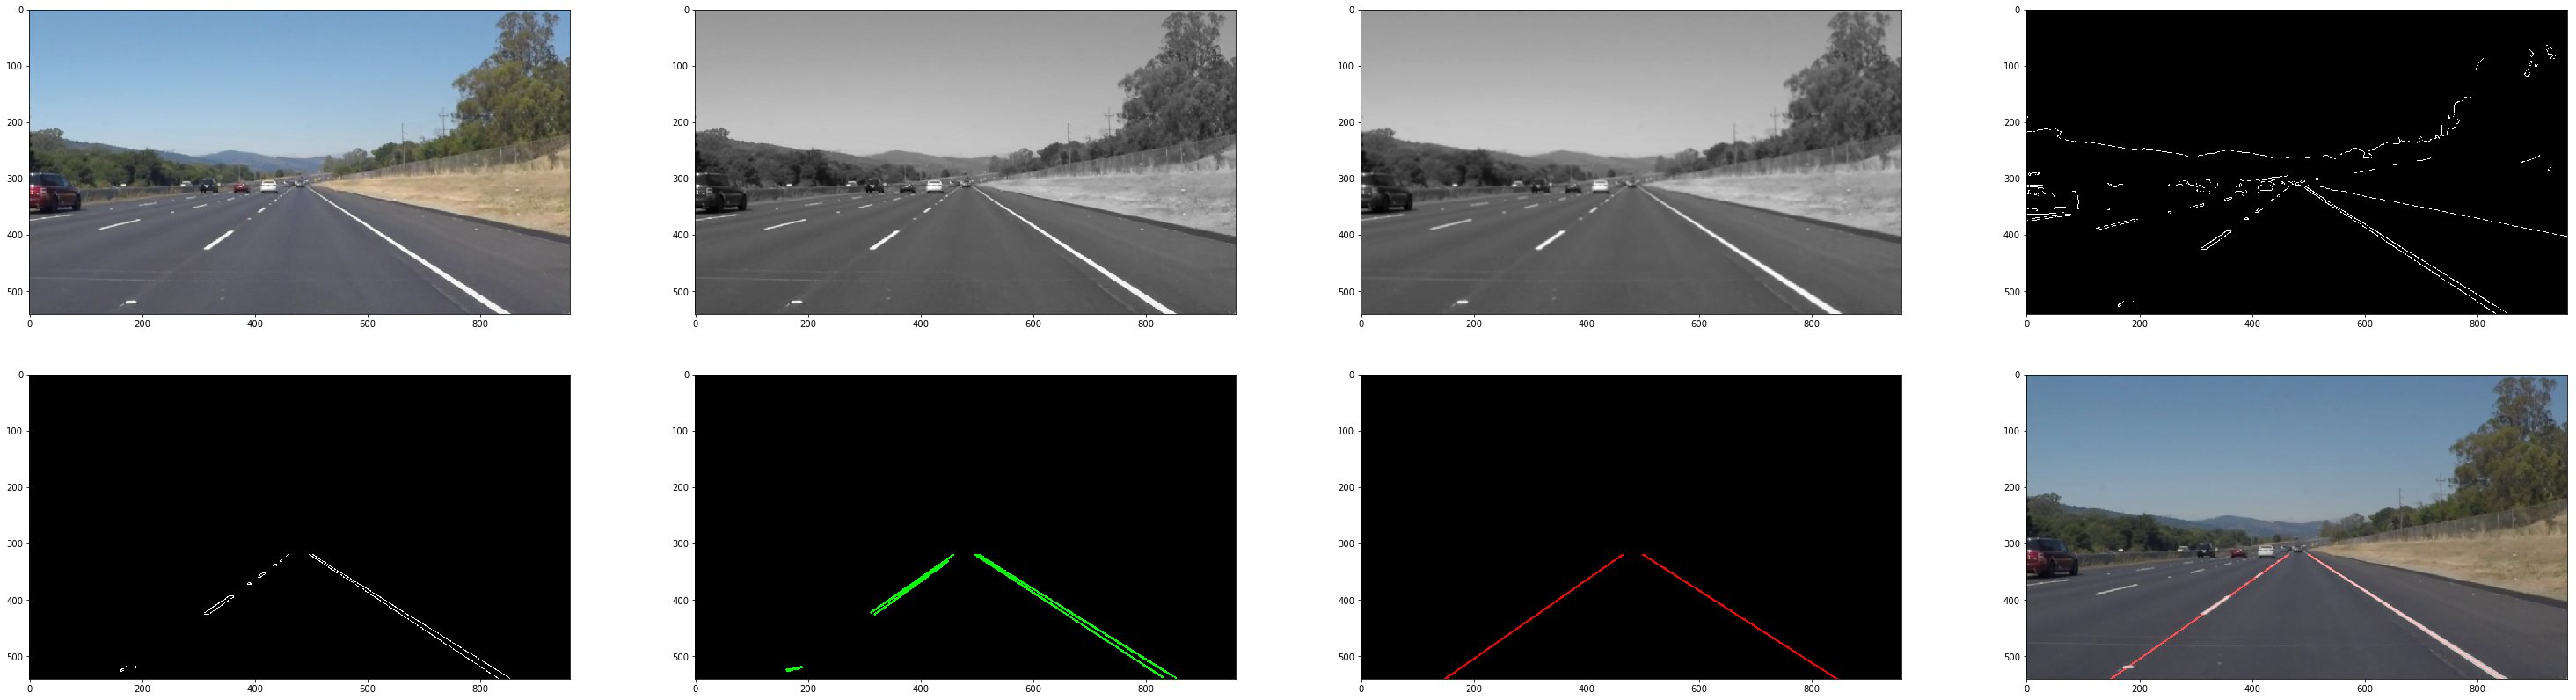

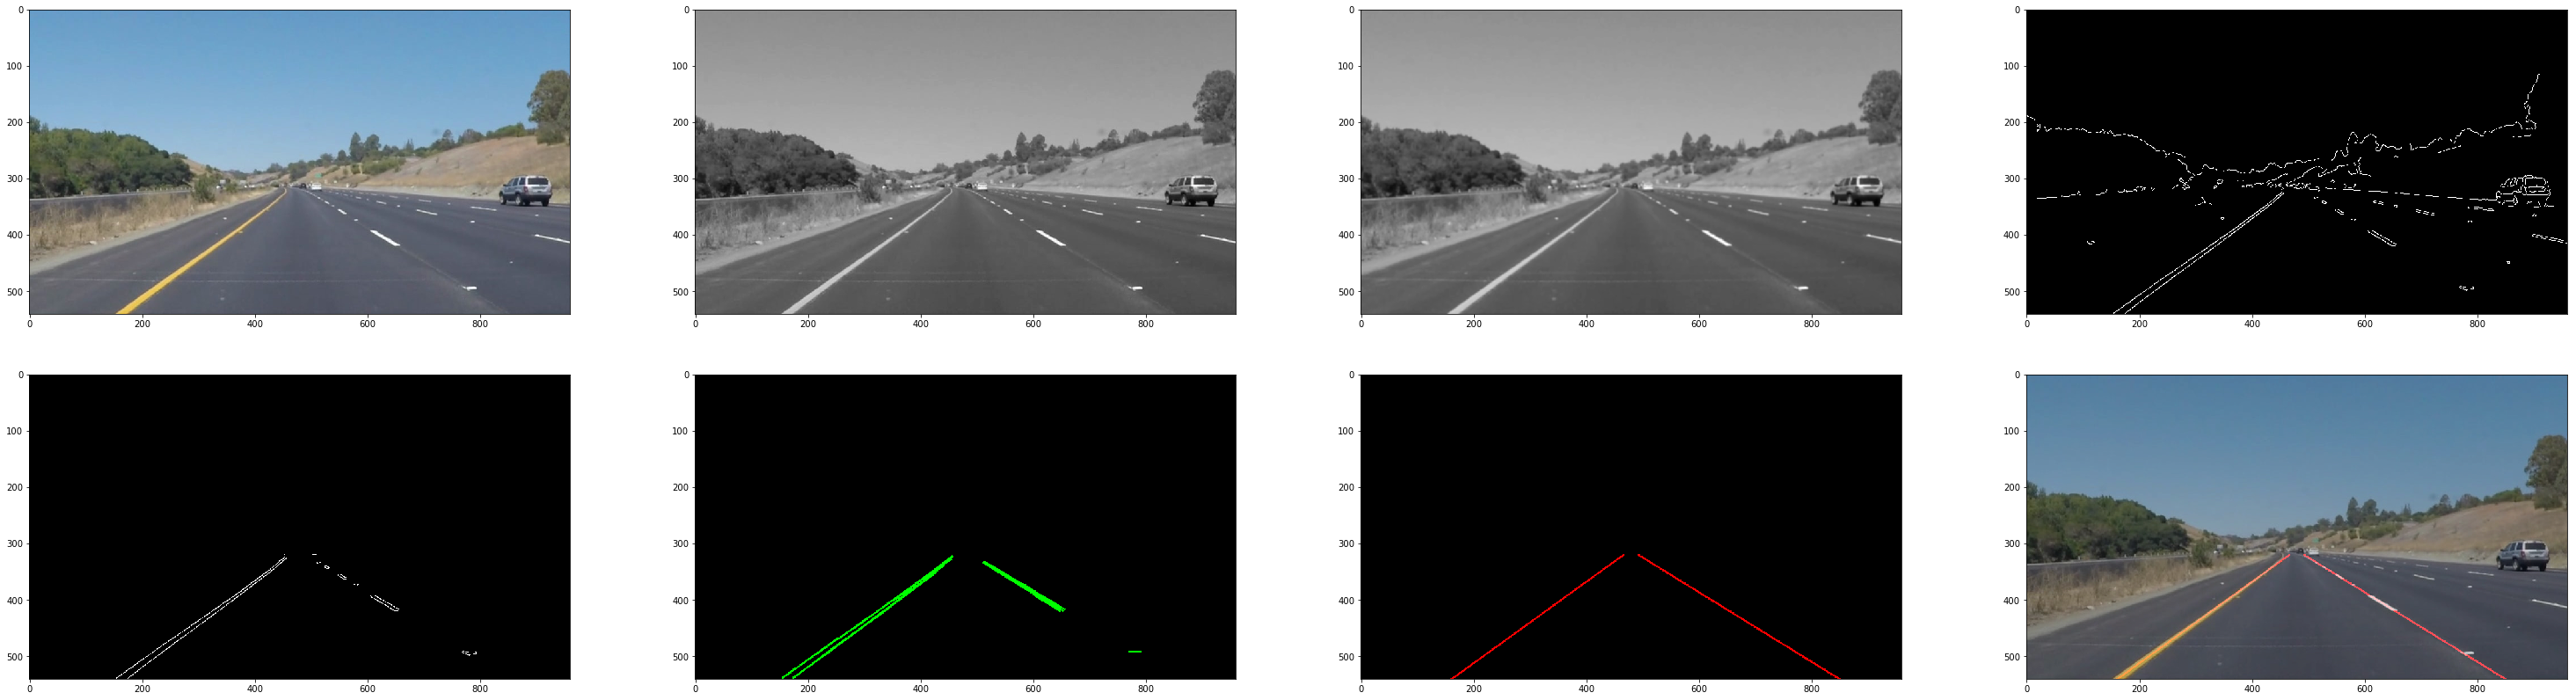

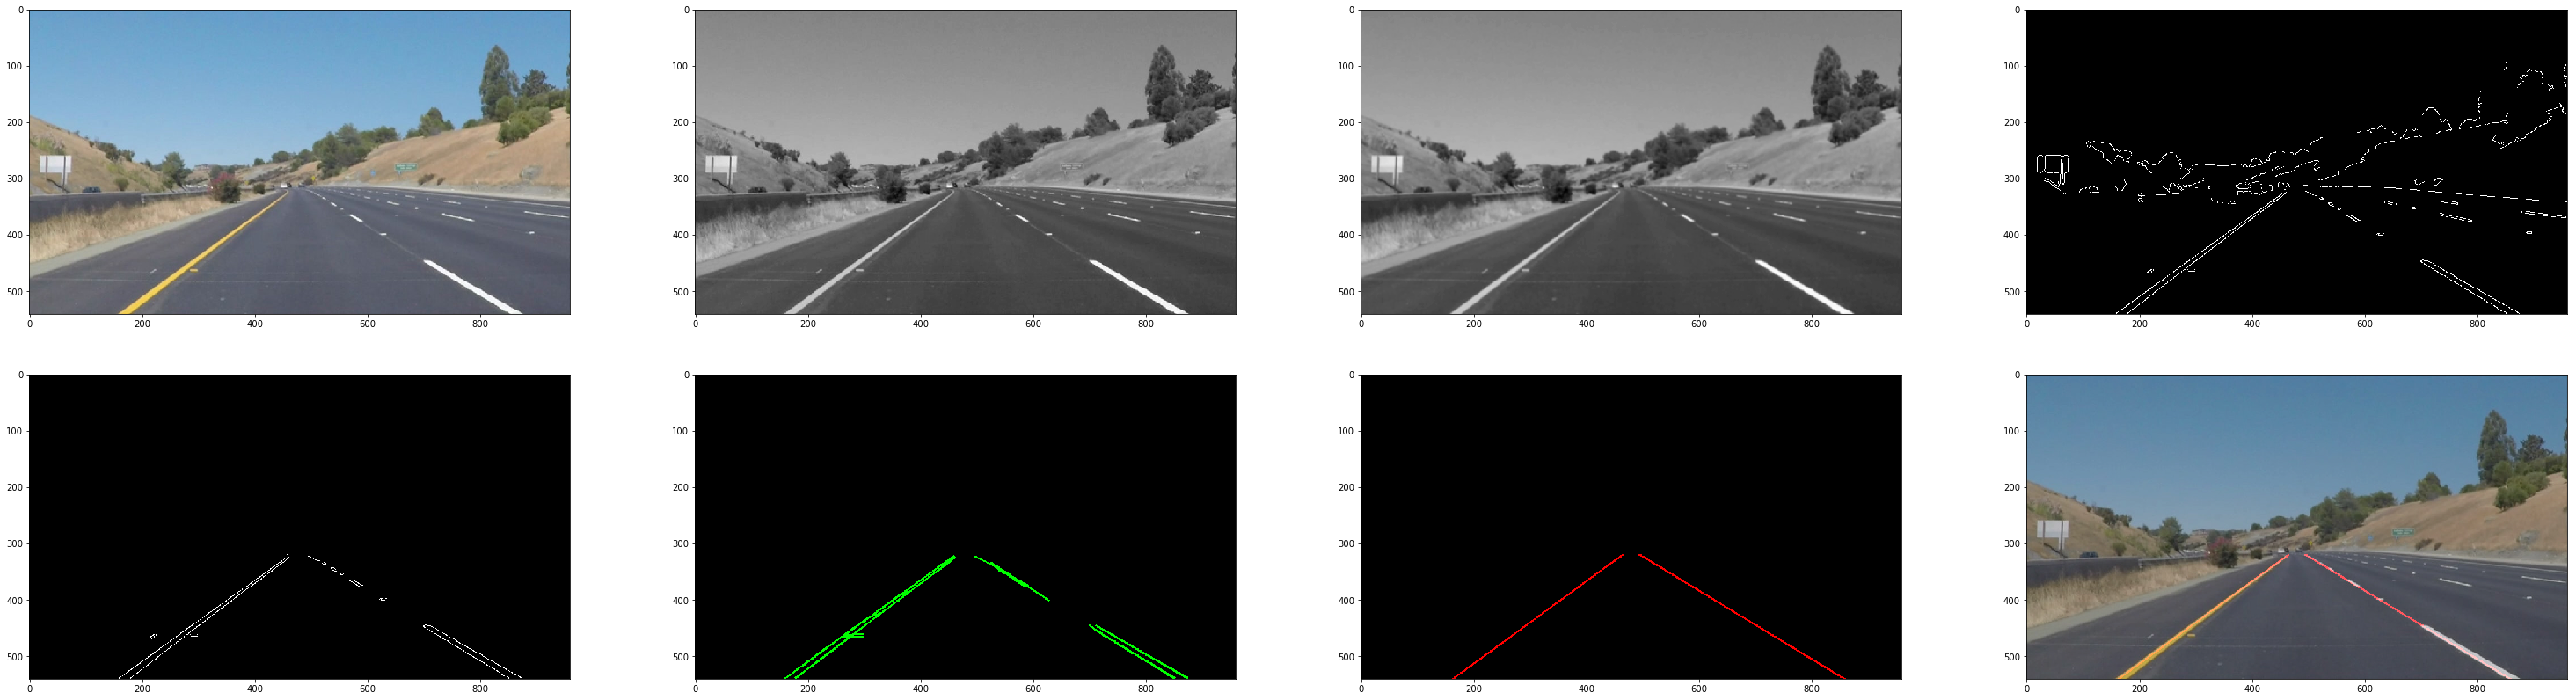

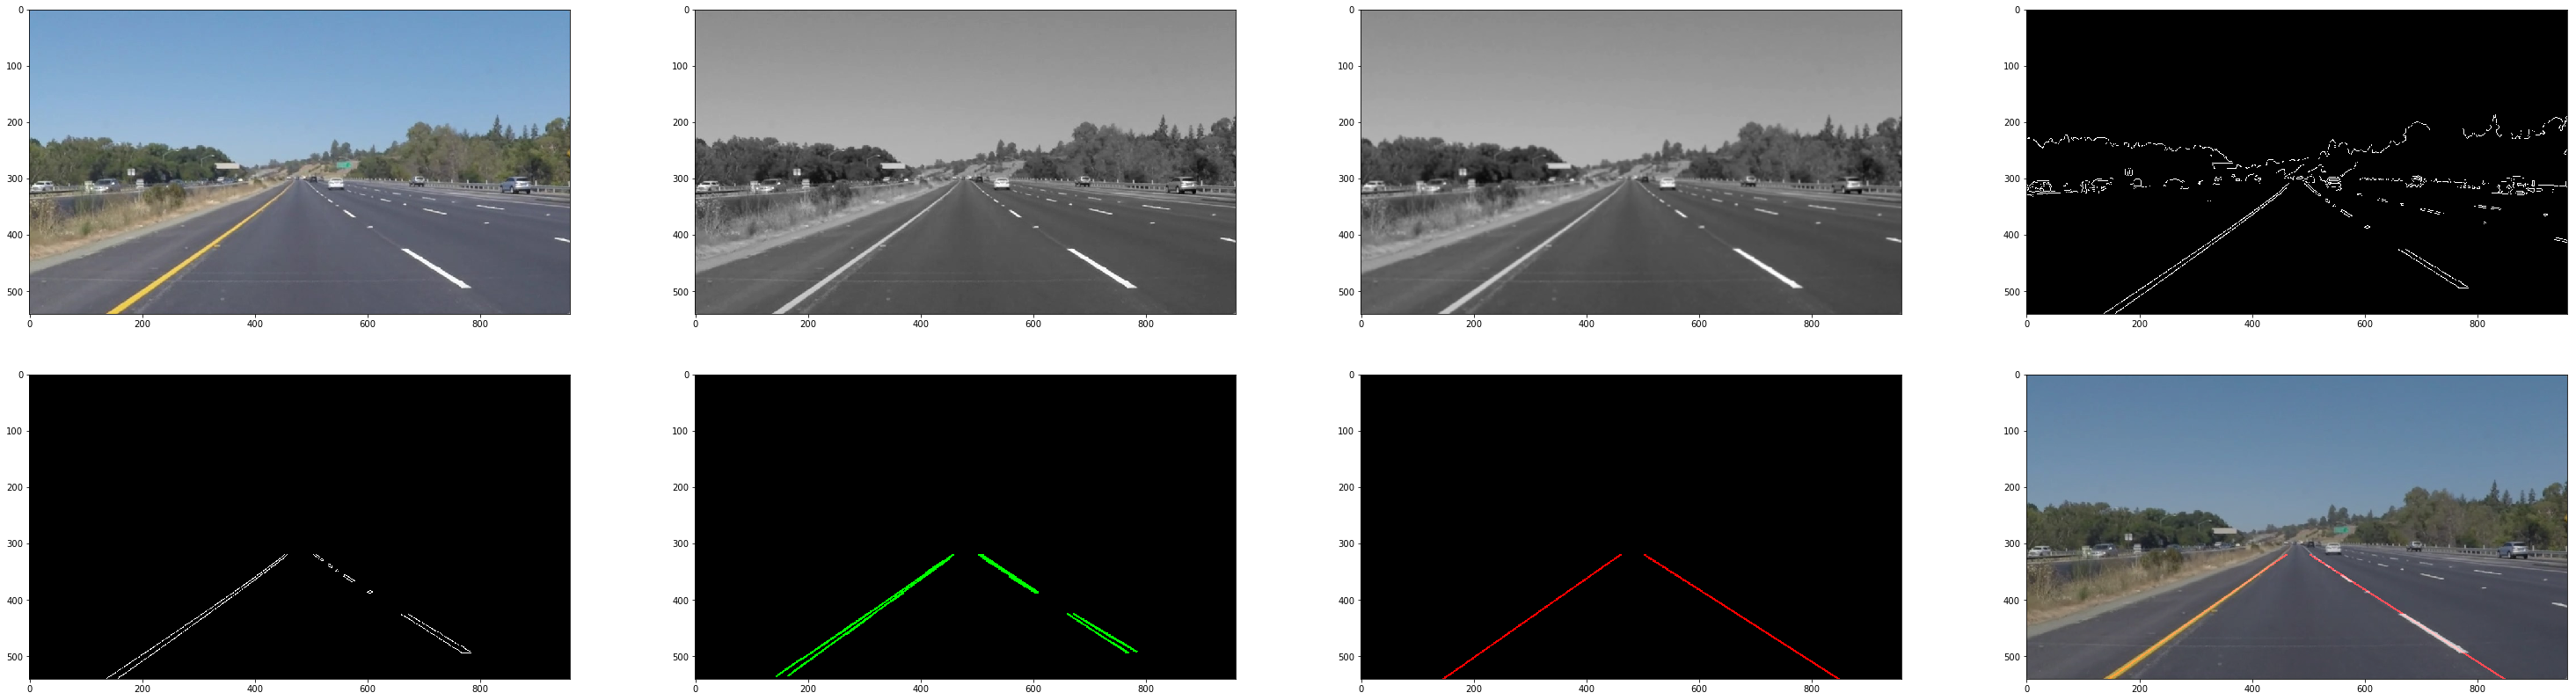

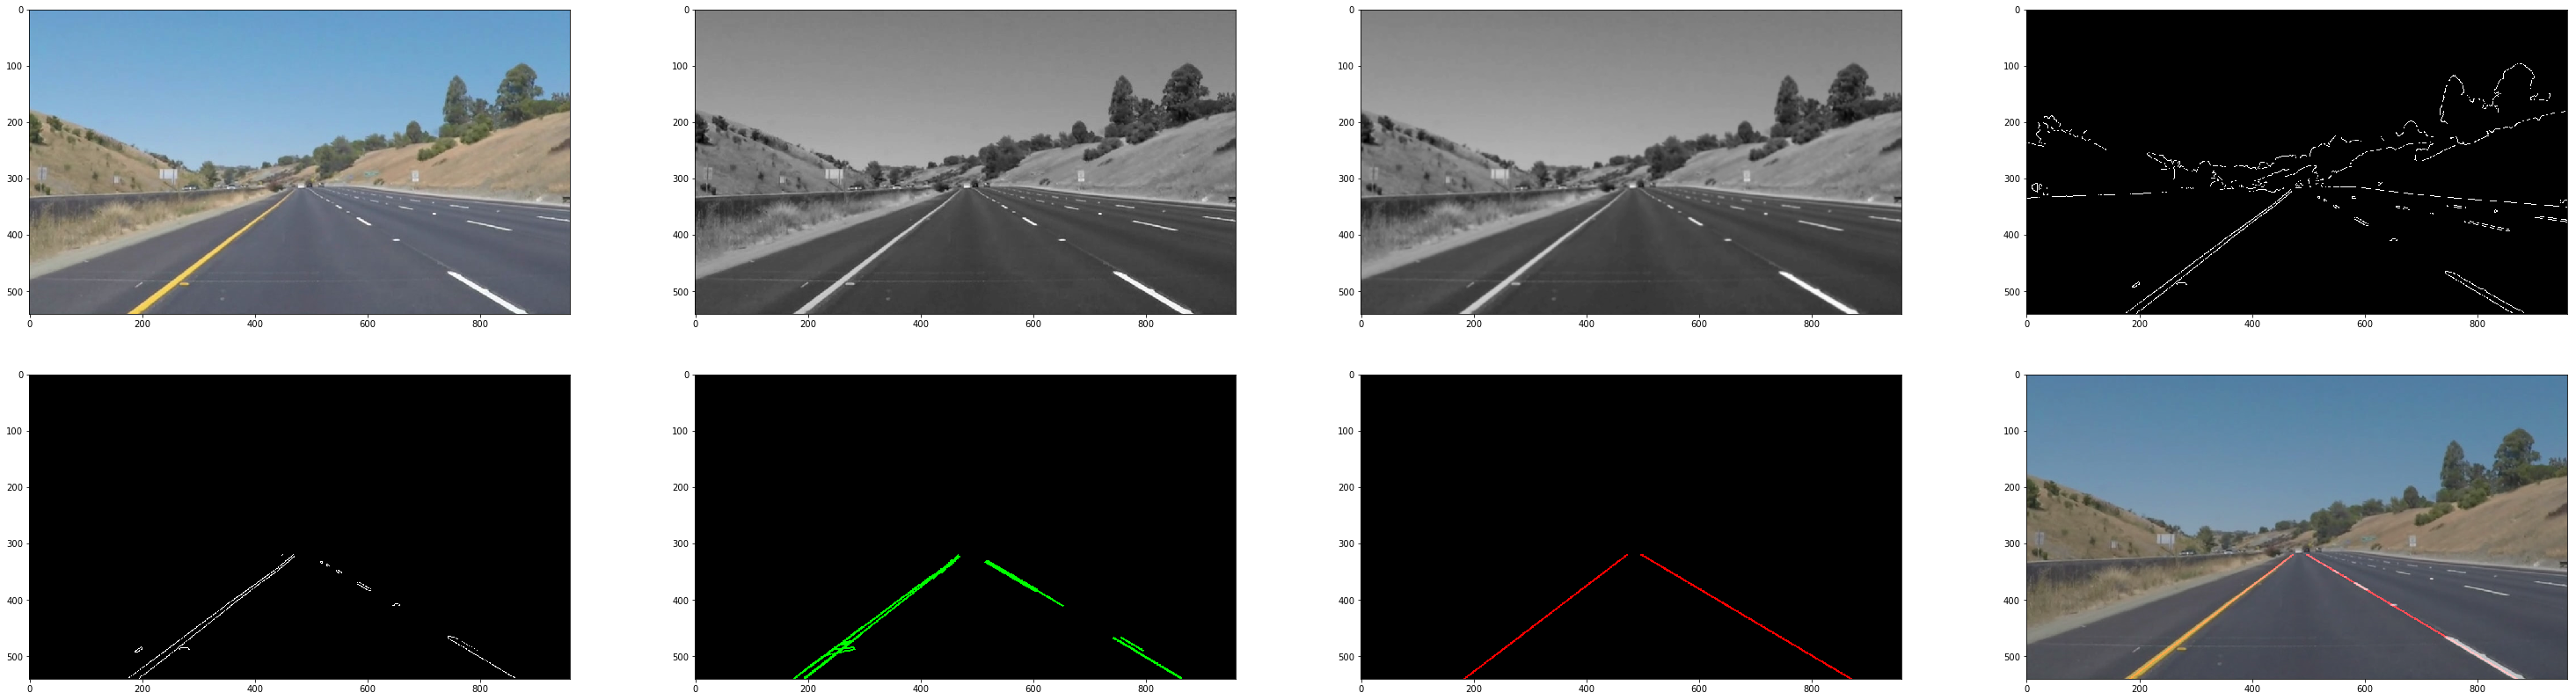

In [26]:
# This is my playground where I tried different settings for kernel size, canny and hough transform. The result
# of my final parameter set is shown in the images below.

# iterates over each test image and apply different algorithms to detect the lane lines.
for image_name in test_images:
    fig = plt.figure()
    fig.set_figheight(14)
    fig.set_figwidth(52)
      
    image = read_image(os.path.join(test_dir,image_name))
    
    ax = fig.add_subplot(241)
    ax.imshow(image)
    
    # convert it to grayscale
    gray = grayscale(image)
    
    ax = fig.add_subplot(242)
    ax.imshow(gray, cmap="gray")
    
    # apply gaussian blur to smooth the images
    blur_gray = gaussian_blur(gray,kernel_size = 5)
    
    ax = fig.add_subplot(243)
    ax.imshow(blur_gray, cmap="gray")
    
    # use canny for edge detection
    edges = canny(blur_gray, low_threshold = 90, high_threshold = 180)
    
    ax = fig.add_subplot(244)
    ax.imshow(edges, cmap="gray")    
    
    # restrict the area where we want to search for lane lines
    vertices = create_roi_vertices(edges)
    roi_image = region_of_interest(edges, vertices)
    
    ax = fig.add_subplot(245)
    ax.imshow(roi_image, cmap="gray")
    
    # apply hough transform to detect lines within the region of interest
    base_img, lines = hough_lines(np.copy(roi_image), rho=2, theta=np.pi/180, threshold=15, min_line_len=20, max_line_gap=40)
    
    # Show all lines that were found
    all_lines = base_img.copy()
    left, right = separate_lines(all_lines, lines)
    
    ax = fig.add_subplot(246)
    ax.imshow(all_lines)
    
    # Apply linear regression on left and right lines and display
    # the detected lines
    interpolated_lines = base_img.copy()     
    # interpolated lines
    yRatio = 0.59  
    from_ = image.shape[0]
    to_ = int(round(yRatio * image.shape[0]))
    draw_lines(interpolated_lines, left, right, from_, to_)
    
    ax = fig.add_subplot(247)
    ax.imshow(interpolated_lines)
    
    # Overlay original image with interpolated lines
    final_image = weighted_img(interpolated_lines, image)
    
    ax = fig.add_subplot(248)
    ax.imshow(final_image)
    
    # finally save images 
    #pipelinename = os.path.splitext(image_name)[0] + "_pipeline.png"    
    #fig.savefig( os.path.join("examples", pipelinename))
    

## Implementation of the Image Processing Pipeline for the Test on Videos

In [6]:
# Download ffmpeg
#import imageio
#imageio.plugins.ffmpeg.download()

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [36]:
def process_image(image): 
    """
    This is the method that is called by moviepy for each image. Every image
    is grayscaled and blurred. Edges in a fixed area of interest are detected
    and hough transform is applied on the detected edges.
    The lines returned by hough transform are then separated into left and right lane
    lines. Finally a single a left and right line is calculated using linear regression.
    """
    
    # 1.) Convert to Gray
    gray = grayscale(image)
    
    # 2.) Smooth image
    blur_gray = gaussian_blur(gray,kernel_size = 7)
    
    # 3.) Use canny and search for edges in ROI
    edges = canny(blur_gray, low_threshold = 80, high_threshold = 180)
    
    # 4.) Create a ROI using a trapezoid
    vertices = create_roi_vertices(edges)
    roi_image = region_of_interest(edges, vertices)
                                  
    # 5.) Use hough transform to find lane lines
    base_img, lines = hough_lines(np.copy(roi_image), rho=2, theta=np.pi/180, threshold=15, min_line_len=20, max_line_gap=15)
    #base_img, lines = hough_lines(np.copy(roi_image), rho=2, theta=np.pi/180, threshold=15, min_line_len=20, max_line_gap=40)
    
    # 6.) Separe lines but do not draw them
    all_lines = base_img.copy()
    left, right = separate_lines(all_lines, lines, draw_lines=True)
    
    # 6.1) Draw left and right lines
    interpolated_lines = base_img.copy()
     
    # smoothed, interpolated lines
    yRatio = 0.59  
    from_ = image.shape[0]
    to_ = int(round(yRatio * image.shape[0]))
    draw_lines(interpolated_lines, left, right, from_, to_)
    
    # 7.)
    final_image = weighted_img(interpolated_lines, image)
    #final_image = weighted_img(all_lines, image)
     
    return final_image

Let's try the one with the solid white lane on the right first ...

In [37]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:07<00:00, 29.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 7.64 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [41]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:21<00:00, 31.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 22.1 s


In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [39]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:15<00:00, 17.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 16.1 s


In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))